<a href="https://colab.research.google.com/github/gokulanv/ToyFederatedLearning/blob/master/TensorFlow/Federated/Genki4k_TFFederated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install --quiet --upgrade tensorflow_federated

%load_ext tensorboard

     |████████████████████████████████| 460kB 4.7MB/s 
     |████████████████████████████████| 92kB 9.9MB/s 
     |████████████████████████████████| 296kB 15.0MB/s 
     |████████████████████████████████| 174kB 14.4MB/s 
     |████████████████████████████████| 1.0MB 19.5MB/s 


In [4]:
import collections
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
from pathlib import Path

import tensorflow as tf
from tensorflow import reshape, nest, config
from tensorflow.keras import losses, metrics, optimizers
import tensorflow_federated as tff
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D


np.random.seed(0)

tff.federated_computation(lambda: 'hi')()

b'hi'

In [0]:
def plot_graph(X, y, format = '-', label=''):
    plt.plot(X, y, format, label=label)
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.grid(True)

In [6]:
_URL = 'https://inc.ucsd.edu/mplab/wordpress/wp-content/uploads/genki4k.tar'

path_to_zip = tf.keras.utils.get_file('genki4k.tar', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'genki4k')

29261824/29255680 [==============================] - 1s 0us/step


In [0]:
labels = list([])

text_file = open(os.path.join(os.path.dirname(path_to_zip), 'labels.txt'), "r")
lines = text_file.read().split('\n')
for line in lines[:4000]:
    labels.append(int(line.split()[0]))

In [0]:
data = list([])

for filename in sorted(glob.glob(os.path.join(os.path.dirname(path_to_zip), "files/*"))):
    data.append(os.path.join(os.path.dirname(path_to_zip), "files/", filename))

In [0]:
def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [178, 178])
    return image.numpy()

imgs = []
erratic_files = []
for i,filename in enumerate(data):
    img = np.array(parse_image(filename))
    if img.shape[2] == 3:
        imgs.append(img)
    else:
        erratic_files.append(i)


imgs = np.asarray(imgs)
data = imgs
labels = np.asarray(labels)[:, None]

In [11]:
ix = 0
for r in erratic_files:
    r -= ix
    labels = np.delete(labels, r, 0)
    ix += 1
labels.shape, data.shape

((3998, 1), (3998, 178, 178, 3))

In [12]:
len(labels), len(data), labels.shape, data.shape
from sklearn.utils import shuffle
X, Y = shuffle(data, labels, random_state=0)
X.shape, Y.shape

((3998, 178, 178, 3), (3998, 1))

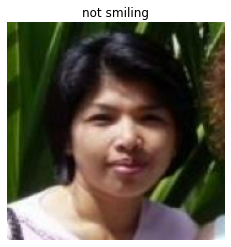

In [13]:
def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title('smiling' if label[0] == 1 else 'not smiling')
  plt.axis('off')

idx = 1149
show(X[idx], Y[idx])

In [0]:
TRAIN_SPLIT_PERCENT = 0.9
split_index = int(len(X) * TRAIN_SPLIT_PERCENT)

x_train, y_train = (X[:split_index], Y[:split_index])
x_val, y_val = (X[split_index:-100], Y[split_index:-100])
x_test, y_test = (X[-100:], Y[-100:])

In [15]:
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.int32)

x_val = x_val.astype(np.float32)
y_val = y_val.astype(np.int32)

x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.int32)

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((3598, 178, 178, 3),
 (3598, 1),
 (300, 178, 178, 3),
 (300, 1),
 (100, 178, 178, 3),
 (100, 1))

In [0]:
total_train_imgs = len(x_train)
federated_clients_dataset_accum = collections.OrderedDict()

NO_OF_CLIENTS = 2
CLIENT_DATA_LEN = total_train_imgs//NO_OF_CLIENTS

for i in range(NO_OF_CLIENTS):
    client_id = 'client_' + str(i)

    start = i * CLIENT_DATA_LEN
    end = (i + 1) * CLIENT_DATA_LEN

    data = collections.OrderedDict((('labels', y_train[start:end]), ('images', x_train[start:end])))
    federated_clients_dataset_accum[client_id] = data

genki_train = tff.simulation.FromTensorSlicesClientData(federated_clients_dataset_accum)

In [17]:
genki_train.element_type_structure

OrderedDict([('labels', TensorSpec(shape=(1,), dtype=tf.int32, name=None)),
             ('images',
              TensorSpec(shape=(178, 178, 3), dtype=tf.float32, name=None))])

In [18]:
genki_train.client_ids

['client_0', 'client_1']

In [19]:
sample_dataset = genki_train.create_tf_dataset_for_client(genki_train.client_ids[0])
element = next(iter(sample_dataset))
element['labels'].numpy()

array([0], dtype=int32)

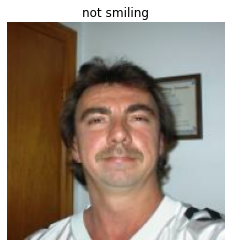

In [20]:
show(element['images'].numpy(), element['labels'].numpy())

In [0]:
NO_OF_CLIENTS = 2
EPOCHS = 4
BATCH_SIZE = 16
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

def preprocess(dataset):

    def batch_format_fn(element):
        return collections.OrderedDict(
            x = tf.reshape(element['images'], [-1, x_train.shape[1], x_train.shape[2], x_train.shape[3]]),
            y = tf.reshape(element['labels'], [-1, 1])
        )

    return dataset.repeat(EPOCHS).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE).map(
        batch_format_fn).prefetch(PREFETCH_BUFFER)


In [22]:
preprocessed_sample_dataset = preprocess(sample_dataset)
tf.nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_sample_dataset)))

OrderedDict([('x', array([[[[2.74509825e-02, 4.31372561e-02, 3.92156877e-02],
                       [2.74509825e-02, 4.31372561e-02, 3.92156877e-02],
                       [2.74509825e-02, 4.31372561e-02, 3.92156877e-02],
                       ...,
                       [9.00859758e-02, 4.70037758e-02, 3.14276032e-02],
                       [9.79731604e-02, 4.31702882e-02, 3.13725509e-02],
                       [9.80392247e-02, 4.31372561e-02, 3.13725509e-02]],
              
                      [[2.74509825e-02, 4.31372561e-02, 3.92156877e-02],
                       [2.74509825e-02, 4.31372561e-02, 3.92156877e-02],
                       [2.74509825e-02, 4.31372561e-02, 3.92156877e-02],
                       ...,
                       [9.00794789e-02, 4.69972827e-02, 3.14211100e-02],
                       [9.79731604e-02, 4.31702882e-02, 3.13725509e-02],
                       [9.80392247e-02, 4.31372561e-02, 3.13725509e-02]],
              
                      [[2.74509

In [23]:
def make_federated_data(client_data, client_ids):
    return [
        preprocess(client_data.create_tf_dataset_for_client(x))
        for x in client_ids
    ]

federated_train_data = make_federated_data(genki_train, genki_train.client_ids)

print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))

Number of client datasets: 2
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 178, 178, 3)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>


In [0]:
def create_keras_model():
    model = Sequential([
        Conv2D(16, 3, padding='same', activation='relu', input_shape=(178, 178 ,3)),
        MaxPooling2D(),
        Conv2D(32, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

In [0]:
def model_fn():
    keras_model = create_keras_model()
    return tff.learning.from_keras_model(keras_model=keras_model,
                                         input_spec=preprocessed_sample_dataset.element_spec,
                                         loss=tf.keras.losses.BinaryCrossentropy(),
                                         metrics=[tf.keras.metrics.BinaryAccuracy()]
                                        )

In [26]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn = model_fn,
    client_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate=0.001),
    server_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate=0.01),
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
state = iterative_process.initialize()
state, tff_metrics = iterative_process.next(state, federated_train_data)

In [0]:
import math

NUM_ROUNDS = 10

tff_train_acc = []
tff_val_acc = []
tff_train_loss = []
tff_val_loss = []

min_val_loss = math.inf

for round_num in range(2, NUM_ROUNDS+1):
    state, tff_metrics = iterative_process.next(state, federated_train_data)
    print('round {:2d}, metrics={}'.format(round_num, tff_metrics))


    if round_num % 10 == 0:
        
        if min_val_loss > tff_metrics.loss:
            min_val_loss = tff_metrics.loss
            model.save_weights('/content/drive/My Drive/genki4k_fedmodel/genki4k_cp.ckpt')

        # Create a callback that saves the model's weights
        checkpoint_path = '/content/drive/My Drive/genki4k_fedmodel/federated_model_{0}_epoch.ckpt'.format(round_num)

        eval_model = create_keras_model()
        eval_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                        loss=tf.keras.losses.BinaryCrossentropy(),
                        metrics=[tf.keras.metrics.BinaryAccuracy()])

        tff.learning.assign_weights_to_keras_model(eval_model, state.model)

        ev_result = eval_model.evaluate(x_val, y_val, verbose=0)
        print(f"Eval loss : {ev_result[0]} and Eval accuracy : {ev_result[1]}")


    tff_train_acc.append(float(tff_metrics.binary_accuracy))
    tff_val_acc.append(ev_result[1])
    tff_train_loss.append(float(tff_metrics.loss))
    tff_val_loss.append(ev_result[0])

metric_collection = {"binary_accuracy": tff_train_acc,
                     "val_binary_accuracy": tff_val_acc,
                     "loss": tff_train_loss,
                     "val_loss": tff_val_loss}


In [61]:
NUM_ROUNDS = 10

for round_num in range(2, NUM_ROUNDS+1):
    state, tff_metrics = iterative_process.next(state, federated_train_data)
    print('round {:2d}, metrics={}'.format(round_num, tff_metrics))

    checkpoint_path = 'training_{0}/cp.ckpt'.format(round_num)
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=True,
                                                    verbose=1)
    if round_num % 5 == 0:
        eval_model = create_keras_model()
        eval_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                        loss=tf.keras.losses.BinaryCrossentropy(),
                        metrics=[tf.keras.metrics.BinaryAccuracy()])

        tff.learning.assign_weights_to_keras_model(eval_model, state.model)


        ev_result = eval_model.evaluate(x_val, y_val, verbose=0)
        print(f"Eval loss : {ev_result[0]} and Eval accuracy : {ev_result[1]}")

    tff_train_acc.append(float(tff_metrics.binary_accuracy))
    tff_val_acc.append(ev_result[1])
    tff_train_loss.append(float(tff_metrics.loss))
    tff_val_loss.append(ev_result[0])

metric_collection = {"binary_accuracy": tff_train_acc,
                     "val_binary_accuracy": tff_val_acc,
                     "loss": tff_train_loss,
                     "val_loss": tff_val_loss}


round  2, metrics=<binary_accuracy=0.5560728311538696,loss=0.6817277669906616>
round  3, metrics=<binary_accuracy=0.5537799000740051,loss=0.6817298531532288>
round  4, metrics=<binary_accuracy=0.5550305843353271,loss=0.6815396547317505>
round  5, metrics=<binary_accuracy=0.553710401058197,loss=0.6814162135124207>
Eval loss : 0.6979812979698181 and Eval accuracy : 0.4333333373069763
round  6, metrics=<binary_accuracy=0.5568371415138245,loss=0.6814156770706177>
round  7, metrics=<binary_accuracy=0.5584352612495422,loss=0.6812710165977478>
round  8, metrics=<binary_accuracy=0.5569066405296326,loss=0.6810750365257263>
round  9, metrics=<binary_accuracy=0.5592690110206604,loss=0.6812495589256287>
round 10, metrics=<binary_accuracy=0.5589216351509094,loss=0.6811380386352539>
Eval loss : 0.696098804473877 and Eval accuracy : 0.4466666579246521


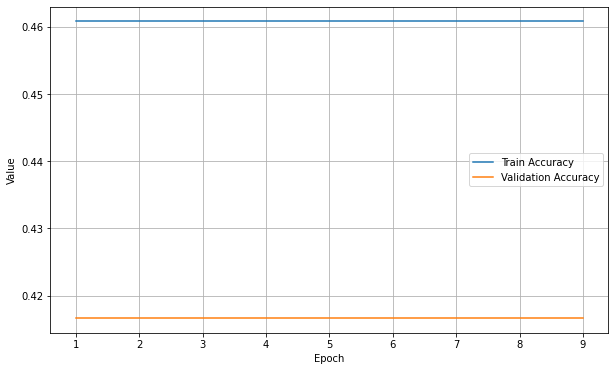

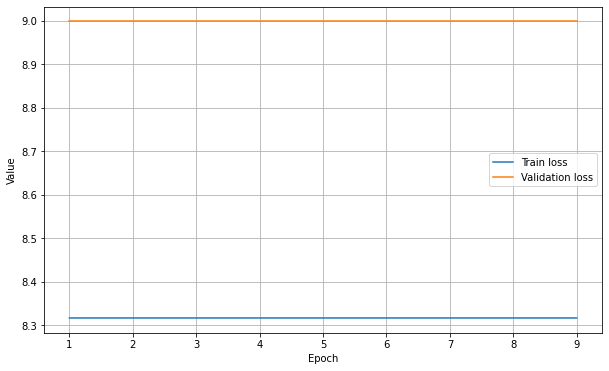

In [54]:
fig = plt.figure(figsize=(10, 6))
plot_graph(list(range(1, 10)), tff_train_acc, label='Train Accuracy')
plot_graph(list(range(1, 10)), tff_val_acc, label='Validation Accuracy')
plt.legend()

plt.figure(figsize=(10, 6))
plot_graph(list(range(1, 10)), tff_train_loss, label='Train loss')
plot_graph(list(range(1, 10)), tff_val_loss, label='Validation loss')
plt.legend()